In [189]:
import json

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = 800

In [2]:
from typing import List, Tuple

In [3]:
with open('train.json') as f:
    objs = [json.loads(item) for item in f.read().strip().split('\n')]
    df = pd.json_normalize(objs)

In [4]:
df.shape

(30000, 702)

Now we have a sparse matrix, where the languages/genres/countries are one-hot encoded. This is a lot better.

Column names have these weird `/m/` codes, let's replace them with human names after checking that each has one unique name

In [5]:
set(df[col].dropna().nunique() for col in df.columns if '/m/' in col)

{1}

In [6]:
df = df.rename(columns={c: c.split('.')[0] + '.' + df[c].dropna().unique()[0] for c in df.columns if '/m/' in c})

In [7]:
df.columns

Index(['title', 'release_date', 'movie_box_office_revenue', 'plot_summary',
       'feature_length', 'languages.Tamil Language', 'genres.Drama',
       'countries.India', 'languages.English Language', 'genres.Thriller',
       ...
       'countries.Republic of China', 'languages.Hinglish',
       'languages.Hindustani language', 'languages.Friulian Language',
       'countries.Malta', 'languages.Frisian, Western Language',
       'languages.Chewa language', 'genres.Tokusatsu', 'genres.Plague',
       'languages.Australian English'],
      dtype='object', length=702)

Much better

Now we a) drop language/country, which we don't need, plus all the metadata features, leaving only plot and genre

In [8]:
df = df.drop(columns=[c for c in df.columns if 'languages' in c or 'countries' in c])
df = df.drop(columns=['title', 'release_date', 'movie_box_office_revenue','feature_length'])
df.columns = [c.split('.')[-1] for c in df.columns]  # remove `genres.` prefix

Now let's make this a nice binary matrix, since each target column only has unique value

In [9]:
df = df.set_index('plot_summary')
df[~df.isna()] = 1
df = df.fillna(0).astype(int).reset_index()

Todo tomorrow: whoops, I think I only need the text features (plot, vectorised, maybe some NLTK/SpaCy feature extraction) and the genre. So maybe get these as labels? 

This is known in sklearn as multilabel. NBd, many classifiers can handle it out of the box, and just take a multi-dim y so we're easy.

The dates as mixed formats is bad, maybe just use years

In [10]:
plt.style.use('fivethirtyeight')

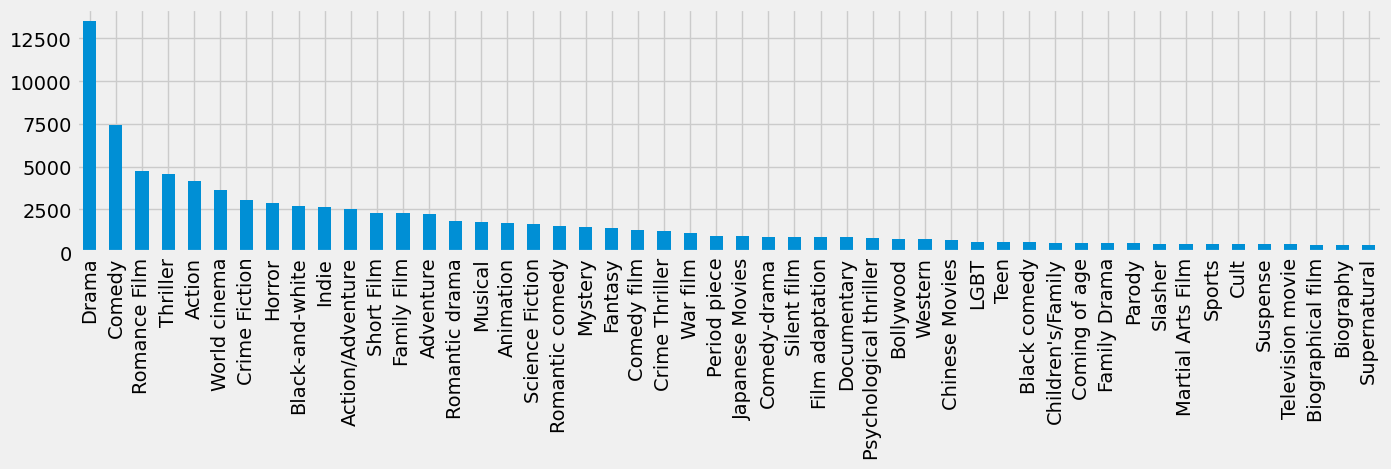

In [11]:
_, ax = plt.subplots(figsize=(15,3))
df.iloc[:, 1:].sum().sort_values(ascending=False).head(50).plot(kind='bar', ax=ax);

Of the 356 genres, there is an long tail which will probably be hard to predict well. Let's see what percentage of the movies each genre has:

In [12]:
with pd.option_context('display.precision', 4):
    print(df.iloc[:, 1:].sum().div(30000).mul(100).sort_values(ascending=False))

Drama                       45.1567
Comedy                      24.7700
Romance Film                15.7933
Thriller                    15.3133
Action                      13.7900
                             ...   
Ninja movie                  0.0033
Private military company     0.0033
Neorealism                   0.0033
Breakdance                   0.0033
Plague                       0.0033
Length: 356, dtype: float64


#### Extracting some textual features

In [13]:
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [14]:
df.plot_summary = df.plot_summary.str.strip('\n')

In [15]:
stop_words = set(stopwords.words('english'))

In [16]:
df.plot_summary = df.plot_summary.apply(lambda s: ' '.join(w for w in s.split() if w.lower() not in stop_words))

In [17]:
p = re.compile(r'[^\w\s]+')
df['plot_summary'] = [p.sub('', x) for x in df['plot_summary'].tolist()]

Let's add a stemmer just in case it improves things. There are other possibilities here: POS tagging, lemmatization, NER, sentiment, and so on. We will start simple.

In [18]:
stemmer = SnowballStemmer("english")

In [19]:
%%time
df['stemmed_plot'] = df['plot_summary'].apply(lambda s: ' '.join(stemmer.stem(y) for y in s.split()))

CPU times: user 25 s, sys: 69.8 ms, total: 25.1 s
Wall time: 25.1 s


#### Prediction

In [97]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import coverage_error, f1_score, label_ranking_average_precision_score, ndcg_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain, MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import LinearSVC

In [21]:
text_col = 'stemmed_plot'

In [22]:
text_col = 'plot_summary'

In [23]:
X, y = df[[text_col]].to_numpy(), df.drop(columns=['plot_summary',
                                                   'stemmed_plot'
                                                  ]).to_numpy()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [25]:
lr = LogisticRegression()
model = OneVsRestClassifier(lr)

In [26]:
text_col_ind = df.columns.get_loc(text_col)

In [27]:
pipeline = Pipeline([
    ("feature_preparation", ColumnTransformer([("text_feature", TfidfVectorizer(), text_col_ind), 
                                               ("drop_text", "drop", text_col_ind)])),
    ("scaling", MaxAbsScaler()),
    ("classifier", model),
])

In [28]:
%%time
pipeline.fit(X_train, y_train)

/Users/josh/miniconda3/envs/pronto/lib/python3.9/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 251 is present in all training examples.
  warnings.warn(
/Users/josh/miniconda3/envs/pronto/lib/python3.9/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 347 is present in all training examples.
  warnings.warn(


CPU times: user 10min 11s, sys: 4min, total: 14min 12s
Wall time: 3min 51s


Pipeline(steps=[('feature_preparation',
                 ColumnTransformer(transformers=[('text_feature',
                                                  TfidfVectorizer(), 0),
                                                 ('drop_text', 'drop', 0)])),
                ('scaling', MaxAbsScaler()),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression()))])

Note that there are some genres that are not represented in the train data, we will deal with this later:

In [29]:
0 in y_train.sum(1)

True

Initial benchmark:

In [32]:
pred = pipeline.predict(X_test)

In [36]:
print("F1 (micro): ", f1_score(y_test, pred, average="micro"))
print("NDCG: ", ndcg_score(y_test, pred))
print("Label ranking average precision: ", label_ranking_average_precision_score(y_test, pred))

F1 (micro):  0.36072089357911324
NDCG:  0.4842706689474524
Label ranking average precision:  0.2618522532153014


#### Can we improve it?

Reducing categories. I did a small amount of manual reduction (doesn't take too long with a decent text editor), going only with obvious choices which do not lose information. Eg not combining "Prison Film" with "Prison Escape". Mostly just synonyms or a term repeated with the word "film". Plus the genre "film" which seems to add zero information.

Idea for improvement - hierarchical classification, do larger categories and then another pass within those categories to further classify. Requires a manual ontology though.

In [37]:
df = df.drop(columns=['Film'])

In [38]:
def combine_categories(df: pd.DataFrame, new_col: str, to_combine: Tuple[str, ...]):
    """
    Combine similar categories into one
    """
    df[new_col] = df[to_combine].any(1).astype(int)
    return df.drop(columns=to_combine)

In [39]:
for new_col, to_combine in [
    ('Aliens', ['Alien Film', 'Alien invasion']),
    ('Adult', ['Adult', 'Pornographic movie', 'Pornography']),
    ('Animation', ['Animation', 'Animated cartoon']),
    ('Anti-war', ['Anti-war', 'Anti-war film']),
    ('Beach Film', ['Beach Film', 'Beach Party film']),
    ('Biography', ['Biography', 'Biographical film', 'Biopic [feature]']),
    ('Buddy film', ['Buddy film', 'Buddy cop',  'Buddy Picture']),
    ("Children's", ["Children's", "Children's/Family", "Children's Entertainment"]),
    ('Comedy', ['Comedy','Comdedy', 'Comedy film']),
    ('Coming of age', ['Coming-of-age film', 'Coming of age']),
    ('Detective', ['Detective', 'Detective fiction']),
    ('Education', ['Education', 'Educational']),
    ('Filipino', ['Filipino', 'Filipino Movies']),
    ('LGBT', ['Gay Interest', 'Gay Themed', 'LGBT']),
    ('Gross out', ['Gross out', 'Gross-out film']),
    ('Legal drama', ['Legal drama', 'Courtroom Drama']),
    ('Monster', ['Monster', 'Monster movie']),
    ('Prison', ['Prison', 'Prison film']),
    ('Superhero', ['Superhero', 'Superhero movie']),
    ('Sword and sorcery', ['Sword and sorcery', 'Sword and sorcery films']),
]:
    df = combine_categories(df, new_col, to_combine)

In [40]:
# make all words lower case (does this make a difference?)
df.plot_summary = df.plot_summary.apply(lambda s: ' '.join(w.lower() for w in s.split()))

In [41]:
s = df.drop(columns=['plot_summary',
                     'stemmed_plot'
                    ]).sum()

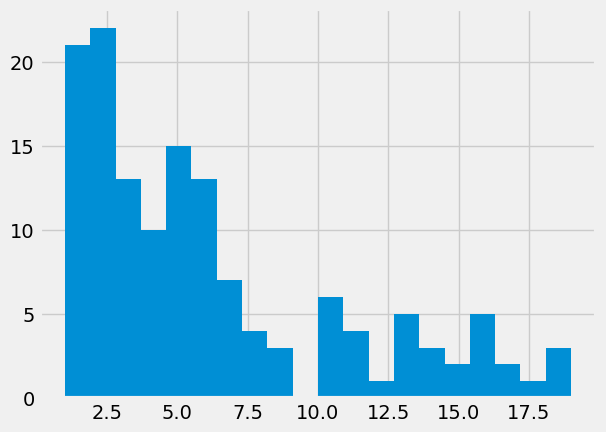

In [42]:
s[s < 20].hist(bins=20);

In [43]:
# we drop genres that have fewer than 10 movies
df = df.drop(columns=(s[s < 10].index))
# and then movies that have no genre
df = df.loc[~df.drop(columns=['plot_summary']).sum(1).eq(0)]

In [44]:
X, y = df[[text_col]].to_numpy(), df.drop(columns=['plot_summary', 
                                                   'stemmed_plot'
                                                  ]).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Prediction pipeline

In [52]:
def train_model(model):
    model = OneVsRestClassifier(model)
    pipeline = Pipeline([
        ("feature_preparation", ColumnTransformer([("text_feature", TfidfVectorizer(), text_col_ind), 
                                                   ("drop_text", "drop", text_col_ind)])),
        ("scaling", MaxAbsScaler()),
        ("classifier", model),
    ])
    pipeline.fit(X_train, y_train)
    return pipeline

In [53]:
model = LogisticRegression()

In [54]:
pipeline = train_model(model)

In [59]:
pred = pipeline.predict(X_test)

Results after tweaking some features:

In [60]:
def print_scores(y_test, pred):
    print("F1 (micro): ", f1_score(y_test, pred, average="micro"))
    print("NDCG: ", ndcg_score(y_test, pred))
    print("Label ranking average precision: ", label_ranking_average_precision_score(y_test, pred))

In [61]:
print_scores(y_test, pred)

F1 (micro):  0.36753951403632934
NDCG:  0.5169319482933487
Label ranking average precision:  0.2748622413872933


So only a small improvement. Some other ideas: maybe we can use a threshold instead of 50% cutoff for classification?

In [66]:
for thresh in np.linspace(0, 1, 9):
    pred = pipeline.predict_proba(X_test) > thresh
    print(thresh, ': ', f1_score(y_test, pred, average="micro"))

0.0 :  0.03118099561453059
0.125 :  0.4708274826901661
0.25 :  0.45988307003358625
0.375 :  0.41928810899493546
0.5 :  0.36753951403632934
0.625 :  0.3100127822752449
0.75 :  0.23525066937494227
0.875 :  0.1354741595584546
1.0 :  0.0


A pretty low threshold gets us a higher F1 score...

In [71]:
from sklearn.metrics import recall_score

In [75]:
pred = pipeline.predict_proba(X_test) > 0.125
recall_score(y_test, pred, average='micro')

0.533816425120773

...but even so the recall is pretty low

Another idea: using a `ClassifierChain` and sorting the columns in a way that the earlier ones give information on the later ones. Sorting by topic is complicated, but I will try a simple lexicographic sort and hope that it gives some improvement (eg `Action,  Action Comedy,  Action Thrillers, Action/Adventure`...)

In [81]:
df = df[sorted(df.columns)]

In [82]:
df = pd.concat([df[['plot_summary',
                    'stemmed_plot'
                   ]], df.drop(columns=['plot_summary', 
                                        'stemmed_plot'
                                       ])], axis=1)

In [83]:
X, y = df[[text_col]].to_numpy(), df.drop(columns=['plot_summary',
                                                   'stemmed_plot'
                                                  ]).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [84]:
text_col_ind = df.columns.get_loc(text_col)

In [91]:
lr = LogisticRegression()
model = ClassifierChain(lr)
pipeline = Pipeline([
    ("feature_preparation", ColumnTransformer([("text_feature", TfidfVectorizer(), text_col_ind), 
                                               ("drop_text", "drop", text_col_ind)])),
    ("scaling", MaxAbsScaler()),
    ("classifier", model),
])

In [92]:
pipeline.fit(X_train, y_train)

/Users/josh/miniconda3/envs/pronto/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josh/miniconda3/envs/pronto/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Pipeline(steps=[('feature_preparation',
                 ColumnTransformer(transformers=[('text_feature',
                                                  TfidfVectorizer(), 0),
                                                 ('drop_text', 'drop', 0)])),
                ('scaling', MaxAbsScaler()),
                ('classifier',
                 ClassifierChain(base_estimator=LogisticRegression()))])

In [93]:
pred = pipeline.predict(X_test)

In [94]:
print_scores(y_test, pred)

F1 (micro):  0.35776516665334507
NDCG:  0.5076882745306561
Label ranking average precision:  0.271682234231526


Results are slightly worse

Some alternative models:

In [140]:
ls = LinearSVC(dual='auto')
mb = MultinomialNB()
sgd = SGDClassifier(loss='log_loss')

In [96]:
for name, model in zip(['Linear SVC', 'Multinomial NB', 'SGDClassifier'], [ls, mb, sgd]):
    print(name)
    pipeline = train_model(model)
    pred = pipeline.predict(X_test)
    print_scores(y_test, pred)

Linear SVC
F1 (micro):  0.39085268075019175
NDCG:  0.5300146978138635
Label ranking average precision:  0.27413621220740236
Multinomial NB
F1 (micro):  0.21244669088611592
NDCG:  0.42139799815645046
Label ranking average precision:  0.1877933684578833
SGDClassifier
F1 (micro):  0.3953311692796464
NDCG:  0.5311005206290924
Label ranking average precision:  0.27271914072643455


In [144]:
pred = (pipeline.predict_proba(X_test) > 0.16).astype(int)

In [145]:
print_scores(y_test, pred)

F1 (micro):  0.4704335722018869
NDCG:  0.6047046705780763
Label ranking average precision:  0.307607206363784


The `SGDClassifier` is slightly better than `LinearSVC`, and quite a bit better than the baseline.

In [146]:
kf = KFold()

In [147]:
scores = []

In [148]:
for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    scores.append((f1_score(y_test, pred, average='micro'), label_ranking_average_precision_score(y_test, pred), ndcg_score(y_test, pred)))

In [149]:
scores

[(0.34695805775787697, 0.26063661704227686, 0.4997599906717157),
 (0.3437551288363696, 0.26129570215831316, 0.5017989681105542),
 (0.3485924112607099, 0.26682276192247417, 0.5047223990892207),
 (0.3500503524672709, 0.2627082913638568, 0.5043256626087165),
 (0.35171823407117525, 0.261037233643433, 0.501164998047868)]

Best results:<br>
F1 (micro): 0.3870788081314397<br>
NDCG: 0.5224115910430287<br>
Label ranking average precision: 0.30418931190807785

In [190]:
joblib.dump(pipeline, "model.pkl")

['model.pkl']

If I were to go further I might:
- Generate more classical NLP features (POS tagging, NER, etc)
- Use word embedding from something like BERT
- Maybe even finetuning an LLM, if it was feasible
- Use something like Optuna to tune the hyperparameters

#### Clean stuff for export

In [102]:
p = re.compile(r'[^\w\s]+')
stop_words = set(stopwords.words('english'))

In [103]:
total_cols = df.drop(columns=['plot_summary',
                              'stemmed_plot'
                             ]).columns

In [178]:
def get_genres_from_plot(plot: str, thresh: float = 0.05) -> List[Tuple[str, str]]:
    plot = p.sub('', ' '.join(w for w in plot.strip('\n').split() if w.lower() not in stop_words))
    pred = pipeline.predict_proba(np.array([plot]).reshape(1, -1))[0].tolist()
    filtered_pred = [(genre, prob) for (genre, prob) in zip(total_cols, pred) if prob > thresh]
    res = sorted([x for x in filtered_pred], key=lambda x: x[1], reverse=True)
    return [(genre, f"{prob:.0%}") for (genre, prob) in res]

In [155]:
s = "Five teens walk into a creepy forest to be butchered by an evil psychopath"

In [204]:
with open('total_cols', 'w') as f:
    for col in total_cols:
        f.write(col + '\n')

In [183]:
get_genres_from_plot(s, 0.15)

[('Horror', '65%'), ('Slasher', '30%'), ('B-movie', '19%')]

In [184]:
s = 'Murugappa small time farm labourer lives widow'

In [185]:
get_genres_from_plot(s, 0.15)

[('Drama', '85%'), ('Romantic drama', '16%')]

In [186]:
s = 'Jim Carey plays a hilarious slapstick clown having wild adventures'

In [187]:
get_genres_from_plot(s, 0.15)

[('Adventure', '46%'),
 ('Black-and-white', '45%'),
 ('Silent film', '22%'),
 ('Family Film', '18%')]

### Design document

Some genres not represented in the train data - do I artifically sample to try get them in, drop less than k, or maybe just aim for top 50?

#### Data issues

reading it from JSON, converting to etc etc

#### Feature extraction

What I did and didn't do and what I would have liked to. Did BOW/with TF-IDF normalisation, scaling, and stripped stopwords and punct. Tried crude stemming but didn't seem to help much. Some cleaning of categories. Would have liked to do some more feature extraction, NER, POS tagging, worth checking if it helps. Feeling is that there are some specfic named entities that might be linked to a lot of these niche genres/
MaxAbsScaler because output of BOW is a sparse matrix

#### Model choice

Talk about what I got from ChatGPT and the sklearn docs. Which models work well with multilabel, which don't deal with lots of small classes etc. Also same for choice of metrics

Mention could use optuna to really crank out those better params. Not a huge difference. Didn't really get model performance very high, but it's a challenging problem. 

Impact of metrics on user - bottom line, probably better to have a more generous threshold and err toward false positives. As a user when I see these I will assume there is some fuzziness, even human judgement isn't always so clear on genre. But cost of a false negative is maybe looking for a film of a certain genre and not finding it at all. Better to have abundance.